**<font color=Black size=5>
    @Project: Statstics<br>
    <br>
    @Program Name: Linear Regression Diagnostics <br>
    <br>
    @Author: Ge Chen  <br>
    <br>
    @Purpose: Select important features and build a classifier to predict obeseness<br>
    <br>
    <br>
</font>**

**<font color=IndianRed size=5>
    Part1. Import necessary modules<br>
</font>**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

**<font color=IndianRed size=5>
    Part 2: Data Preprocess for the classifier
</font>**

<font color=Black size=4>
    Data preprocess steps for the 1st classifier are:
    
    
    1. Load data from original .csv file (The file path should be modified by your own).
    
    2. drop useless features in feature matrix, including seq, race_2, filter_, obese. Use np.nan to replace missing data. Convert original binary features (1, 2) into (1, 0). 
    
    3. Drop the features whose null value rate exceeds 25%.
    
    4. Drop unnecessary features. After that, the features contain 'pcalorie', 'pprotein', 'pcalcium', 'pcalprot', 'pcalcarb', 'nutr75', 'race75', 'carb', 'calcium', 'calories', 'calsumpf', 'cals_fat', 'cal_prot', 'cal_carb', 'age75','sex', 'educat4',  'diet75', 'calstd', 'bmi75','income5', 'seden', 'eatusual', 'actrec75', 'exerec75', 'diab75dx'
    
    5. Drop row data with NAN.
    
    6. convert some features into dummy variables.
</font>

In [8]:
"""
@Class Name:DataPreprocessor()
@use: load the original data from .csv files
"""
class DataPreprocessor():
    def __init__(self, path):
        """
        @function: initinal function
        @input:
            1.path: the .csv file path, list type
        """
        self.__path = path
        
    def Load(self):
        """
        @function: load function
        @input: 
            1.self: the class instance
        @return:
            1.df: original data, dataframe type
        """
        df =  pd.read_excel(self.__path)
        #print (df.info())
        return df
    
    def FindMissValue(self, df): # find the blank values and replace them with NAN
        """
        @function: FindMissValue
        @input: 
            1.df: original dataframe
        @return:
            2.df: dataframe after replacing and dropping columns with missing value rate > 0.25
        """        
        
        m = df.shape[0] # sample number
        print ('sample number:', m)
        df = df.replace({'nutr75': 8, 'obese75': 8, 'weight75':888.9, 'height': 89, 'actrec75': 8, 
                        'exerec75': 8, 'drinkoft': 8, 'smokin75': 88, 'ces_d': 99}, np.nan) # find the missing values
        df = df.replace({'obese75': 2}, 0) # change the label value, 1:obese, 0: not obese
        df = df.replace({'race75': 2}, 0) # because there are only 2 values in the column "race75", 1:white, 0:negro, no others
        df = df.replace({'sex': 2}, 0) # 1: M, 0: F
        df = df.replace({'diet75': 2}, 0) # are you on a special diet? 1: yes, 0: no
        df = df.replace({'seden': 2}, 0) # 1:non-sedentary, 0:sedentary
        df = df.replace({'drinkoft': 9}, 0) # 
        
        df = df.replace({'educat4': 1}, 0) # regroup the column 'educate4'
        df = df.replace({'educat4': 2}, 0)
        df = df.replace({'educat4': 3}, 1)
        df = df.replace({'educat4': 4}, 1)
        
        NullRate = df.isnull().sum()/m # calculate the null rates of each column
        FeatureDropIndex = (NullRate[NullRate > 0.25]).index # get the column names whose null rate exceed 0.25
        df.drop(FeatureDropIndex, axis = 1, inplace = True) # drop the columns with 0.25 null rate or more
        '''smoke4ct, ces_d, diet_wt, drinkoft, wlk2blck, reach51b will be dropped because their null rate exceed 0.25'''
        return df
         
    
    def SelectFeatureManually(self, df):
        """
        @function: FindMissValue
        @input: 
            1.df: dataframe after replacing and dropping columns with missing value rate > 0.25
        @return:
            2.df_selected: select useful features manually
        @use:
           select the useful feature, the goal is to find the other factors related to bmi75
           dropped feature and reasons:
           weight75: directly calculate bmi75
           height: directly calculate bmi75
           bodyfat1: calculated by bmi75
           leanbod1: calculated by bodyfat1
           obese75: labels used in Logistic Regression
        """
        df_selected = df.loc[:, ['pcalorie', 'pprotein', 'pcalcium', 'pcalprot', 'pcalcarb', 'nutr75', 
                                 'race75', 'carb', 'calcium', 'calories', 'calsumpf',
                                'cals_fat', 'cal_prot', 'cal_carb', 'age75','sex', 'educat4', 
                                 'diet75', 'calstd', 'bmi75','income5', 'seden', 'eatusual', 
                                 'actrec75', 'exerec75', 'diab75dx']]
        return df_selected
        
    def DropNa(self, df):
        """
        @function: DropNa
        @input: 
            1.df: dataframe
        @return:
            1. x: feature matrix
            2. y: labels
        """ 
        df.dropna(inplace = True)
        df.index = range(len(df))
        y = df['bmi75']
        x = df.drop(['bmi75'], axis = 1)
        return x, y
    
    def GetDummy(self, X):
        """
        @function: GetDummy
        @input: 
            1.X: feature Matrix
        @return:
            1.GroupColumnList: grouped column list. We convert an original feature into multiple dummy variables, 
            then we use a list to store these dummy variable names. 
            An example of grouped column list: 
            ['age75', 'cal_carb', 'cal_prot', 'calcium', 'calories', 'cals_fat', 
            'calstd', 'calsumpf', 'carb', 'diet75', 'educat4', 'nutr75', 'pcalcarb',
            'pcalcium', 'pcalorie', 'pcalprot', 'pprotein', 'race75', 'seden', 'sex',
            ['income5_1.0', 'income5_2.0', 'income5_3.0', 'income5_4.0'], 
            ['eatusual_1.0', 'eatusual_2.0', 'eatusual_3.0', 'eatusual_4.0'],
            ['actrec75_1.0', 'actrec75_2.0'], ['exerec75_1.0', 'exerec75_2.0'], 
            ['diab75dx_1.0', 'diab75dx_2.0', 'diab75dx_3.0']]
            2. df_AfterDummy: feature matrix after dummy
        """ 
        
        
        '''transfer several features with dummy variables'''
        '''wlk2blck: 1-4
           reach51b: 1-4
           educat4: 1-4, generate four dummy features
           income5: 1-5, generate five dummy features
           eatusual:1-5
           actrec75: 1-3
           exerec75: 1-3
           diab75dx: 1, 2, 3, 9
           drinkoft: 1-6'''
        '''Get the column name list for dummy'''
        TotalColumnList = X.columns # all column names
        DummyList = ['income5', 'eatusual', 'actrec75', 'exerec75', 'diab75dx'] # columns which are need to be converted into dummy variables.
        NoDummyList = TotalColumnList.difference(DummyList) # columns which are not required to be converted into dummy variables.
        NoDummyFeatureMatrix = df.loc[:, NoDummyList]
        GroupedColumnList = list(NoDummyList)
        
        '''Normalize the features which are not dummy features '''
        min_max_scaler = preprocessing.MinMaxScaler()
        NoDummyFeatureMatrix = pd.DataFrame(min_max_scaler.fit_transform(NoDummyFeatureMatrix))
        NoDummyFeatureMatrix.columns = NoDummyList
        print (NoDummyFeatureMatrix.head())
        
        
        FeatureMatrix = NoDummyFeatureMatrix
        '''dummy features'''
        for column in DummyList:
            DummyTemp = pd.get_dummies(df[column], prefix = column)
            TempColumnName = DummyTemp.columns[:-1] # drop the last variables in each group of dummy variables
            GroupedColumnList.append(list(TempColumnName))
            FeatureMatrix = FeatureMatrix.join(DummyTemp.loc[:, TempColumnName])
        print (GroupedColumnList)
        return FeatureMatrix, GroupedColumnList 

In [9]:
if __name__=="__main__":
    path = r'C:\dataset\statics dataset\ndata.xls'
    DP = DataPreprocessor(path)
    OriginalData = DP.Load()
    df = DP.FindMissValue(OriginalData)
    df = DP.SelectFeatureManually(df)    
    Features, Labels = DP.DropNa(df)
    FeatureMatrix, GroupedColumnNames = DP.GetDummy(Features)
    print (FeatureMatrix.info())
    print (Labels.head())

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
sample number: 5962
      age75  cal_carb  cal_prot   calcium  calories  cals_fat    calstd  \
0  0.259259  0.239564  0.230307  0.102269  0.174027  0.135937  0.751612   
1  0.555556  0.301201  0.123561  0.083445  0.214980  0.085817  0.719735   
2  0.111111  0.235967  0.107504  0.080733  0.121543  0.067178  0.699677   
3  0.518519  0.157541  0.070893  0.090831  0.065712  0.035440  0.615914   
4  0.629630  0.464442  0.272875  0.110749  0.236647  0.131253  0.669766   

   calsumpf      carb  diet75  educat4  nutr75  pcalcarb  pcalcium  pcalorie  \
0  0.172043  0.239564     1.0      1.0     0.0  0.405355  0.103152  0.145374   
1  0.145835  0.301201     0.0      1.0     0.0  0.607093  0.084050  0.185022   
2  0.114000  0.235967     0.0      1.0     0.0  0.601358  0.082139  0.103524   
3  0.067902  0.157541     0.0      0.0     0.0  0.650268  0.091691  0.057269   
4  0.239930  0.464442     1.0      1.0     0.0  0.577159

c:\development\1stprj\1stprj\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
"""
significance testing for each feature
"""
for column in FeatureMatrix.columns:
    x = FeatureMatrix[column]
    x = sm.add_constant(x)
    Pvalue = sm.OLS(Labels, x).fit().pvalues[column]
    print (column, ':', Pvalue)    

c:\development\1stprj\1stprj\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


age75 : 0.03746084560342918
cal_carb : 4.445455355536375e-17
cal_prot : 0.003793934954153553
calcium : 1.2728103128831774e-10
calories : 1.0326828626692838e-13
cals_fat : 1.1445376123995709e-08
calstd : 7.587895441989536e-14
calsumpf : 1.3133624250218252e-13
carb : 4.445455355537497e-17
diet75 : 0.009483346153227322
educat4 : 3.4917160827078326e-08
nutr75 : 0.0
pcalcarb : 0.02440148658720227
pcalcium : 3.650541432170334e-12
pcalorie : 7.30491353796556e-08
pcalprot : 6.828590857673993e-11
pprotein : 0.1666365133948115
race75 : 5.3262083544068156e-08
seden : 0.005235081765227153
sex : 1.2715201039908238e-12
income5_1.0 : 0.00402799298219652
income5_2.0 : 0.30222111960639847
income5_3.0 : 0.15013358597185084
income5_4.0 : 0.2867588715922731
eatusual_1.0 : 6.222347173605035e-10
eatusual_2.0 : 0.11260450781485236
eatusual_3.0 : 0.7537435363910074
eatusual_4.0 : 0.41834627216779297
actrec75_1.0 : 3.636154565422274e-05
actrec75_2.0 : 0.01204498729876618
exerec75_1.0 : 6.180914774259656e-05
ex

**<font color=IndianRed size=5>
    Part 3: Use stepwise & backwise to select important features
</font>**

In [12]:
class FeatureSelect():
    def __init__(self, features, labels, columnlist):
        self.__features = features
        self.__labels = labels
        self.__columnlist = columnlist.copy() # creat a copy
        
    def StepwiseBackward(self, threshold_in=0.01, threshold_out=0.1):
        '''
        Linear model designed by forward selection, evaluated by P value.
        Please refer to: 
        https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
           Parameters: 
           -----------
           self.__features : pandas DataFrame with all possible predictors
           self.__labels : response

           Returns:
           --------
           ColList: queues of columns (dummy features are not in a list)
           PvalueRec : the corresponding P values
           ColRec: queues of columns (dummy features are in a list)
           '''        
        x = self.__features
        y = self.__labels
        x = sm.add_constant(x) # add the constant column
        columnlist = self.__columnlist
        ColList = ['const'] # the first column is the const column
        ColRec = ['const']
        Pvalue_const = sm.OLS(y, x['const']).fit().pvalues['const']
        PvalueRec = [Pvalue_const] # the first P value is const column's        
        while len(columnlist) > 0:
            print ('--------------------------------------')
            Flag = False
            BestPvalue = 0 
            PvalueList = []
            '''forward selection'''
            for column in columnlist:
                if not isinstance(column, list): # if this column is not dummy feature
                    x_columns = ColList + [column] # calculate the adj R2 after adding this column
                    x_temp = x.loc[:, x_columns] # the temp feature matrix after adding this column
                    fit = sm.OLS(y, x_temp).fit() # OLS fit
                    PvalueList.append(fit.pvalues[column])                    
                else: # if this column is a dummy feature, which contains a series of sub-features
                    DummyPvalueList = []
                    for DummyFeature in column:
                        x_columns = ColList + [DummyFeature]
                        x_temp = x.loc[:, x_columns]
                        fit = sm.OLS(y, x_temp).fit()
                        DummyPvalueList.append(fit.pvalues[DummyFeature])
                    PvalueList.append(max(DummyPvalueList))                                        
            BestPvalue = min(PvalueList)
            BestColumn = columnlist[PvalueList.index(min(PvalueList))]
            if BestPvalue < threshold_in: # if the obtained adj R2 is higher than the best adj R2
                ColRec.append(BestColumn)
                if isinstance(BestColumn, list): # if current best column is a series of dummy features
                    ColList.extend(BestColumn)
                else:
                    ColList.append(BestColumn)
                PvalueRec.append(BestPvalue)
                print ('Add', BestColumn, 'with the P value:', BestPvalue)
                print ('ColList is', ColList)
                columnlist.remove(BestColumn)
                Flag = True
            else:
                print ('the minimum P value is greater than the threshold %f, stepwise stop' % threshold_in)
            
            '''backward step'''
            fit_back = sm.OLS(y, x.loc[:, ColList]).fit()
            pvalues_back = fit_back.pvalues.iloc[1:] # get the P value list of every column in the ColList except 'const'
            worst_pval = pvalues_back.max()
            #print ('the worst P value is ', worst_pval)
            if worst_pval > threshold_out:
                Flag = True
                worst_feature = pvalues_back.argmax() # return the index of the wrost feature
                if worst_feature in ColList:
                    ColList.remove(worst_feature)
                    ColRec.remove(worst_feature)
                    print ('delete feature:', worst_feature)
                else:
                    for column in ColRec:
                        if isinstance(column, list) and worst_feature in column:
                            ColList.remove(column)
                            [ColList.remove(DumColumn) for DumColumn in column]
                            print ('delete feature:', column)            
            if Flag == False:
                break
        return ColList, PvalueRec, ColRec
    
    def plotR2adj(self, Features, R2adjs):
        x = range(len(Features))
        plt.figure(num = 3, figsize = (8, 8))
        plt.plot(x, R2adjs, marker = 'o', color = 'blue')
        #plt.ylim(0, 1)
        plt.show()
            

In [13]:
if __name__=="__main__":
    print ('stepwise and backward Feature selection')
    FS = FeatureSelect(FeatureMatrix, Labels, GroupedColumnNames)
    ColNameList1, PvalueRec1, ColNameRec1 = FS.StepwiseBackward(0.05, 0.1)
    #stat1.plotR2adj(ColNameRec1, PvalueRec1)
    print ('the final Column List is:')
    print (ColNameList1)   

stepwise and backward Feature selection
--------------------------------------
Add nutr75 with the P value: 0.0
ColList is ['const', 'nutr75']
--------------------------------------
Add pcalprot with the P value: 4.513252184945087e-07
ColList is ['const', 'nutr75', 'pcalprot']
--------------------------------------
Add race75 with the P value: 1.073020489725972e-05
ColList is ['const', 'nutr75', 'pcalprot', 'race75']
--------------------------------------
Add calcium with the P value: 0.0003471796977087922
ColList is ['const', 'nutr75', 'pcalprot', 'race75', 'calcium']
--------------------------------------
Add age75 with the P value: 0.001245290960854677
ColList is ['const', 'nutr75', 'pcalprot', 'race75', 'calcium', 'age75']
--------------------------------------
Add educat4 with the P value: 9.982136195022015e-05
ColList is ['const', 'nutr75', 'pcalprot', 'race75', 'calcium', 'age75', 'educat4']
--------------------------------------
Add pcalcium with the P value: 0.0073877980495466

In [14]:
"""
Select the features according to the stepwise and backward results and add intercept.
"""
if __name__=="__main__":
    FeatureAfterSelect = (sm.add_constant(FeatureMatrix)).loc[:, ColNameList1]
    print (FeatureAfterSelect.head())

   const  nutr75  pcalprot  race75   calcium     age75  educat4  pcalcium  \
0    1.0     0.0  0.267574     1.0  0.102269  0.259259      1.0  0.103152   
1    1.0     0.0  0.149813     1.0  0.083445  0.555556      1.0  0.084050   
2    1.0     0.0  0.169591     0.0  0.080733  0.111111      1.0  0.082139   
3    1.0     0.0  0.183704     1.0  0.090831  0.518519      0.0  0.091691   
4    1.0     0.0  0.223179     1.0  0.110749  0.629630      1.0  0.111748   

     calstd  
0  0.751612  
1  0.719735  
2  0.699677  
3  0.615914  
4  0.669766  


**<font color=IndianRed size=5>
    Part 4: Perform regression Diagnositics
</font>**

In [16]:
class RegressionDiagnostics():
    def __init__(self, features, labels):
        self.__features = features
        self.__labels = labels
        
    def GetOLSResult(self):
        x = self.__features
        y = self.__labels
        fit = sm.OLS(y, x).fit()
        print (fit.summary())
        return x
    
    def DropFeaturesByPvalue(self, FeatureMatrix):
        x_drop = FeatureMatrix.drop(['wlk2blck_2.0', 'wlk2blck_3.0','eatusual_2.0', 'eatusual_3.0', 'eatusual_4.0',
                                    'diab75dx_1.0', 'diab75dx_2.0', 'diab75dx_3.0','educat4_3.0',
                                    'drinkoft_3.0', 'drinkoft_4.0', 'drinkoft_5.0'], axis = 1)
        fit = sm.OLS(self.__labels, x_drop).fit()
        print ('after dropping features according to P values')
        print (fit.summary())
        return x_drop
    
    def CheckLinearAndMulticollinearity(self):
        '''check the line and Multicollinearity'''
        Corr = []
        PvalueList = []
        ContinuousColumns = ['pcalprot', 'calcium', 'age75', 'pcalcium', 'calstd']
        for column in self.__features.columns:
            if column in ContinuousColumns:
                r, Pvalue = stats.pearsonr(self.__features[column], self.__labels)
            else:
                r, Pvalue = stats.pointbiserialr(self.__features[column], self.__labels)
            Corr.append(r)
            PvalueList.append(Pvalue)
        df_LinearCorr = pd.DataFrame({'correlations': Corr, 'P values': PvalueList})
        df_LinearCorr.index = self.__features.columns
        print ('-----------check the linear relationship----------')
        print (df_LinearCorr)
        '''calculate VIF to check the multicollinearity'''
        VIF_list = pd.Series([variance_inflation_factor(self.__features.values, i) for i in range(self.__features.shape[1])], 
                             index=self.__features.columns)
        print ('-----------check the Multicollinearity----------')
        print (VIF_list)        
        #return x
    
    def CheckResidNormality(self, x):
        '''check the normality'''
        fit = sm.OLS(self.__labels, x).fit()
        resid = fit.resid
        
        # plot PP and QQ figures
        pp_qq_plot = sm.ProbPlot(resid)
        pp_qq_plot.ppplot(line = '45')
        plt.title('P-P Plot')
        pp_qq_plot.qqplot(line = 'q')
        plt.title('Q-Q Plot')# 显示图形
        plt.show()
        
        # also use Shapiro check to check 
        print ('Shapiro Check')
        print (stats.shapiro(resid))
    
    def CheckResidHomogeneity(self, x):
        fit = sm.OLS(self.__labels, x).fit()
        resid = fit.resid
        
        # plot standard residial figure
        plt.scatter(fit.predict(), (fit.resid-fit.resid.mean())/fit.resid.std())
        plt.xlabel('Prediction')
        plt.ylabel('Standard Resid')
        plt.axhline(y = 0, color = 'r', linewidth = 2)
        plt.show()
        

In [17]:
if __name__=="__main__":
    RD = RegressionDiagnostics(FeatureAfterSelect, Labels)
    RD.GetOLSResult() # use OLS to build the predictor
    RD.CheckLinearAndMulticollinearity()

                            OLS Regression Results                            
Dep. Variable:                  bmi75   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     282.0
Date:                Wed, 24 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:39:08   Log-Likelihood:                -12790.
No. Observations:                4571   AIC:                         2.560e+04
Df Residuals:                    4562   BIC:                         2.566e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8853      0.317     81.708      0.0

c:\development\1stprj\1stprj\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [18]:
'''It is found that there is Multicollinearity between the calcium and the pcalcium'''
'''The independence of residuals is shown by Durbin-Watson in the OLS Regression Results'''
if __name__=="__main__":    
    FeatureMatrix = FeatureAfterSelect.drop(['calcium'], axis = 1).copy() # drop the column "calcium" to avoid multicollinearity
    RD2 = RegressionDiagnostics(FeatureMatrix, Labels)
    RD2.GetOLSResult() # use OLS to build the predictor
    RD2.CheckLinearAndMulticollinearity()

                            OLS Regression Results                            
Dep. Variable:                  bmi75   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     314.7
Date:                Wed, 24 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:40:20   Log-Likelihood:                -12808.
No. Observations:                4571   AIC:                         2.563e+04
Df Residuals:                    4563   BIC:                         2.568e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0689      0.288     87.195      0.0

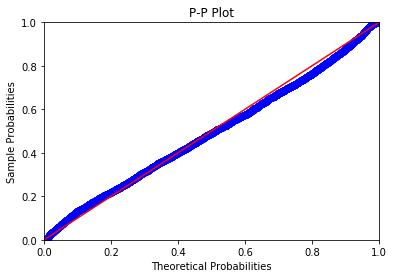

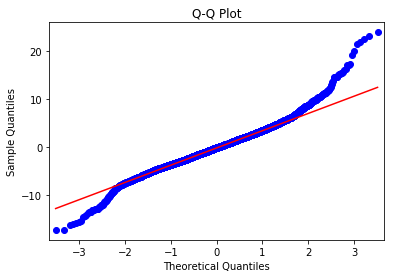

Shapiro Check
(0.9747728705406189, 1.0581525189510015e-27)


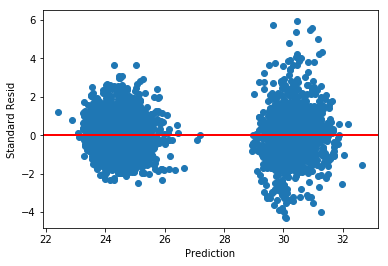

In [19]:
if __name__=="__main__": 
    RD2.CheckResidNormality(FeatureMatrix) # check the normality of residuals
    RD2.CheckResidHomogeneity(FeatureMatrix) # check the homogeneity